## Syndrome extraction

The syndrome extraction protocol operates by detecting changes in stabilizer measurement outcomes that ideally give a $0$ measurement result. Because syndrome extraction requires the use of noisy gates, syndrome measurements must be repeated multiple times within a single QEC cycle to be FT to syndrome measurement errors.

In [48]:
# Imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

stabilizers = [
    [1,2,3,4],
    [2,3,5,6],
    [3,4,6,7]
]

## Unflagged circuits
<img src="./pic/unflagged-circuits.png" width="500"/>

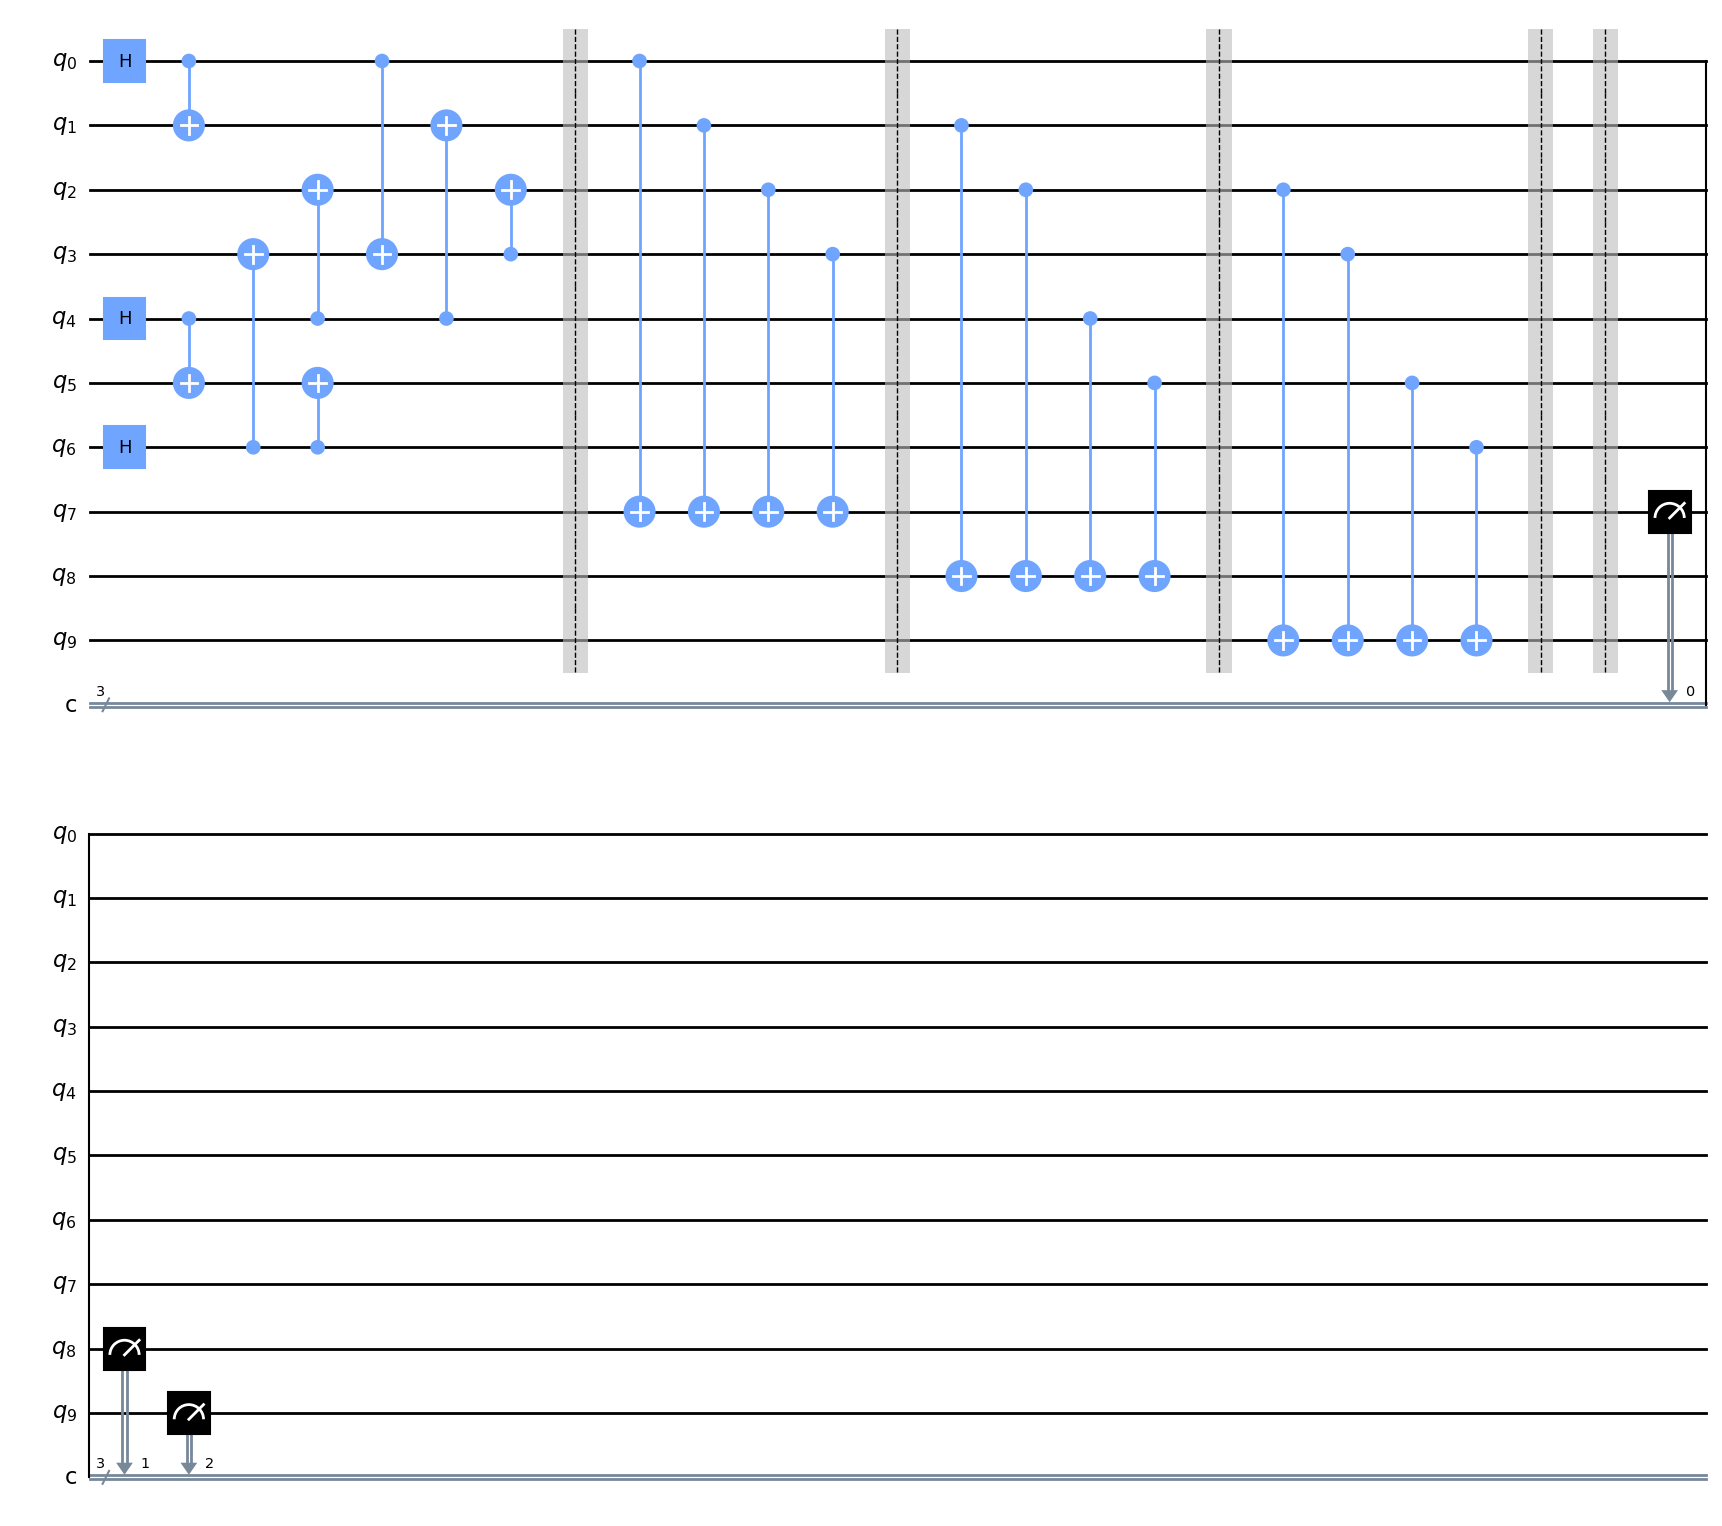

In [49]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

unflagged_circuit_1 = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
unflagged_circuit_1.h(qreg[0])
unflagged_circuit_1.h(qreg[4])
unflagged_circuit_1.h(qreg[6])
unflagged_circuit_1.cx(qreg[0], qreg[1])
unflagged_circuit_1.cx(qreg[4], qreg[5])
unflagged_circuit_1.cx(qreg[6], qreg[3])
unflagged_circuit_1.cx(qreg[4], qreg[2])
unflagged_circuit_1.cx(qreg[6], qreg[5])
unflagged_circuit_1.cx(qreg[0], qreg[3])
unflagged_circuit_1.cx(qreg[4], qreg[1])
unflagged_circuit_1.cx(qreg[3], qreg[2])

unflagged_circuit_1.barrier()

for s in range(len(stabilizers)):
    stabilizer = stabilizers[s]
    for qubit_num in stabilizer:
        unflagged_circuit_1.cx(qreg[qubit_num - 1], qreg[7 + s])
    unflagged_circuit_1.barrier()

unflagged_circuit_1.barrier()

unflagged_circuit_1.measure(qreg[7:], creg)

unflagged_circuit_1.draw("mpl")

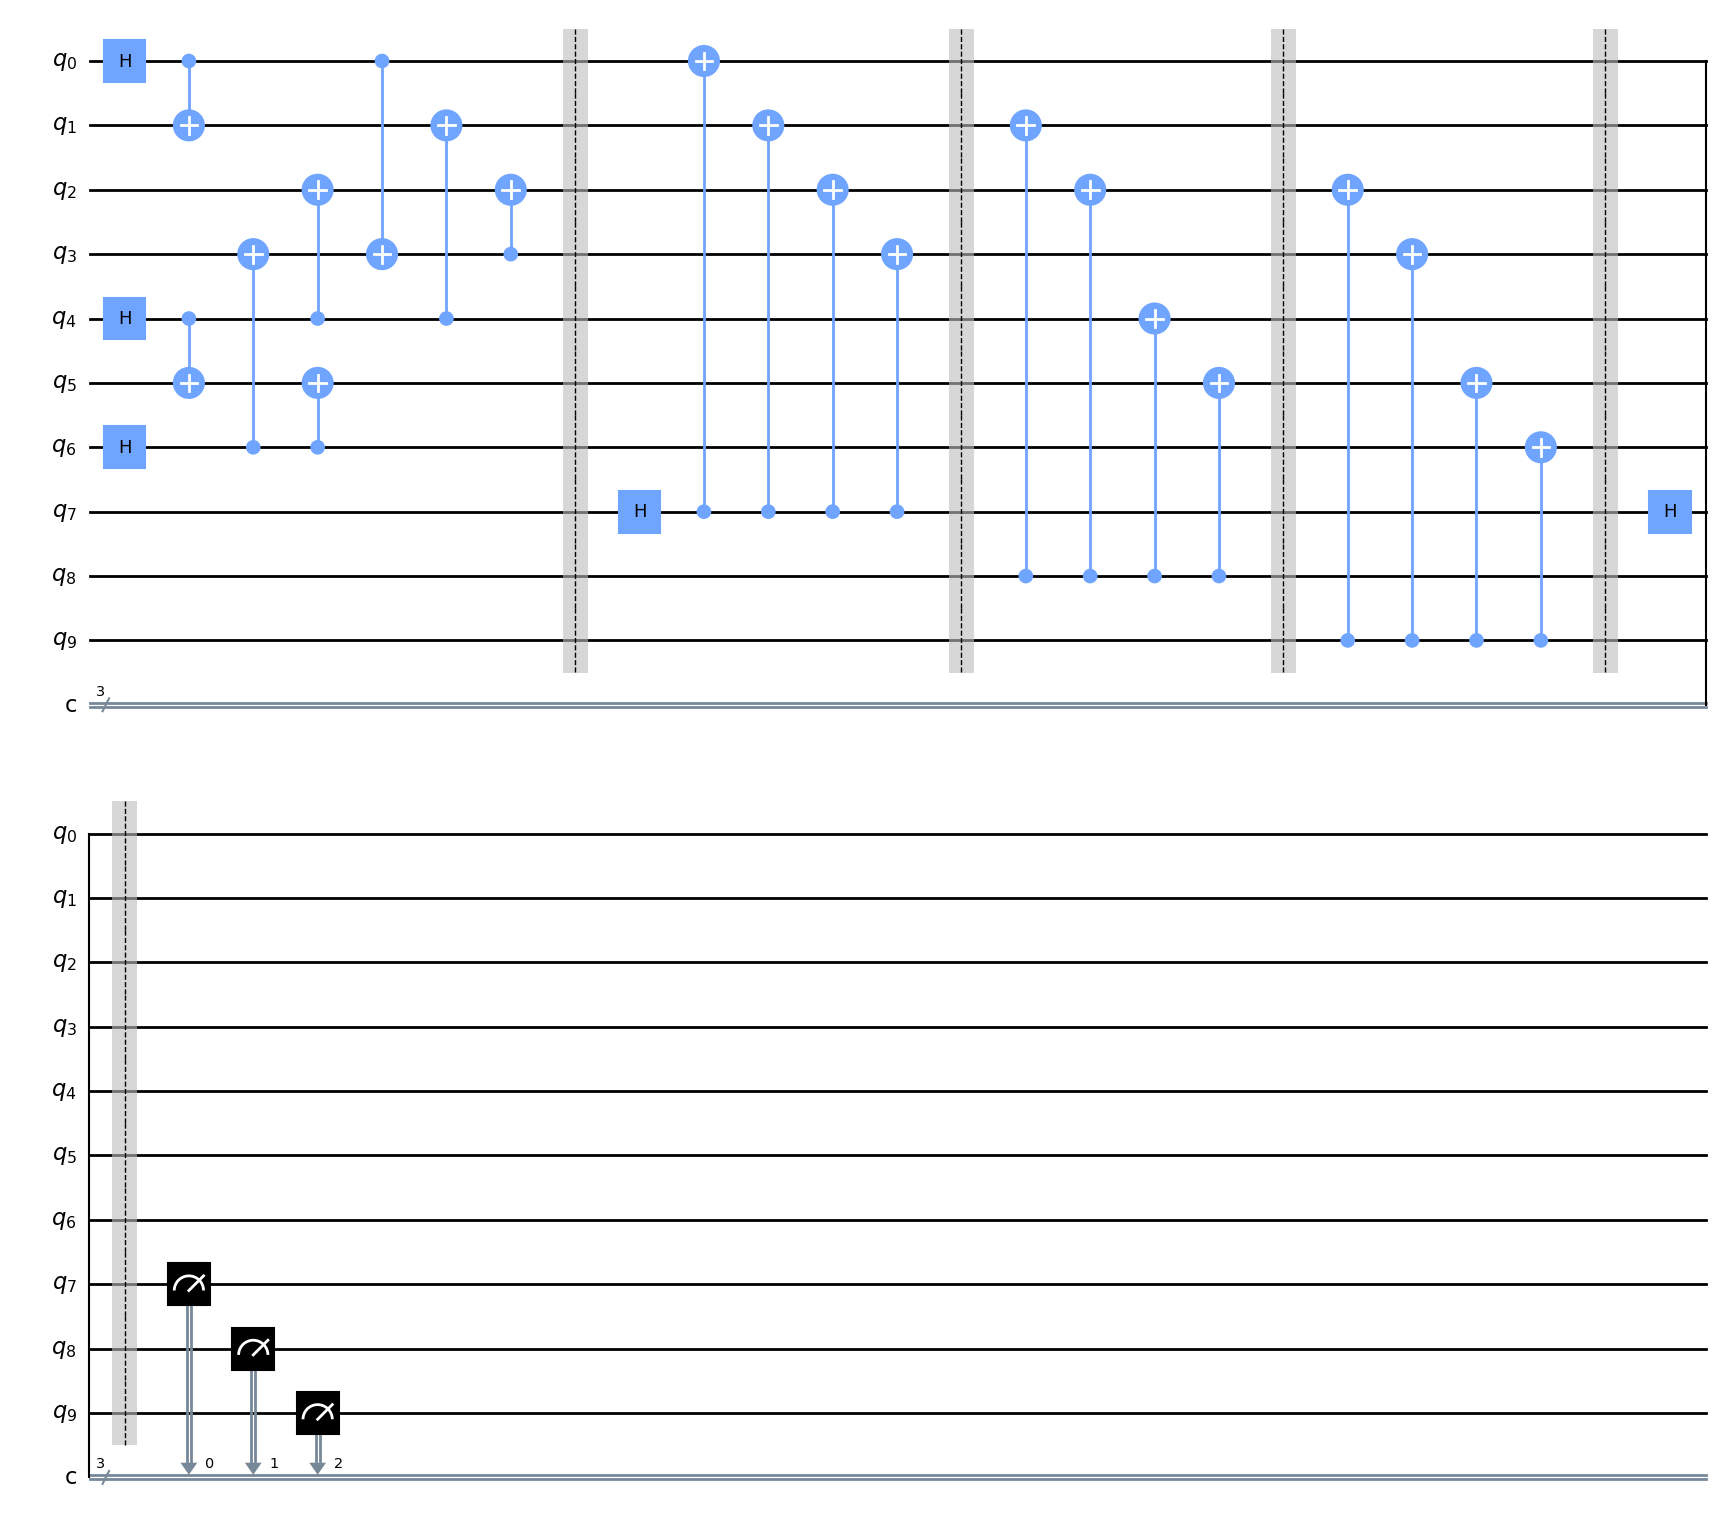

In [50]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

unflagged_circuit_2 = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
unflagged_circuit_2.h(qreg[0])
unflagged_circuit_2.h(qreg[4])
unflagged_circuit_2.h(qreg[6])
unflagged_circuit_2.cx(qreg[0], qreg[1])
unflagged_circuit_2.cx(qreg[4], qreg[5])
unflagged_circuit_2.cx(qreg[6], qreg[3])
unflagged_circuit_2.cx(qreg[4], qreg[2])
unflagged_circuit_2.cx(qreg[6], qreg[5])
unflagged_circuit_2.cx(qreg[0], qreg[3])
unflagged_circuit_2.cx(qreg[4], qreg[1])
unflagged_circuit_2.cx(qreg[3], qreg[2])

unflagged_circuit_2.barrier()

unflagged_circuit_2.h(qreg[7])

for s in range(len(stabilizers)):
    stabilizer = stabilizers[s]
    for qubit_num in stabilizer:
        unflagged_circuit_2.cx(qreg[7 + s], qreg[qubit_num - 1])
    unflagged_circuit_2.barrier()

unflagged_circuit_2.h(qreg[7])

unflagged_circuit_2.barrier()

unflagged_circuit_2.measure(qreg[7:], creg)

unflagged_circuit_2.draw("mpl")

## First flagged parallel circuit $\{S^f_1, S^f_5, S^f_6\}$

<img src="./pic/first-flag.png" width="500"/>


### Single qubit error

The following is an example of single qubit bit-flip $X$ error happening on the 7-th data qubit $q_6$ (Fig.11 from Quantinuum's paper). This error can be detected with a stabilizer $S_6 = Z_3Z_4Z_6Z_7$.


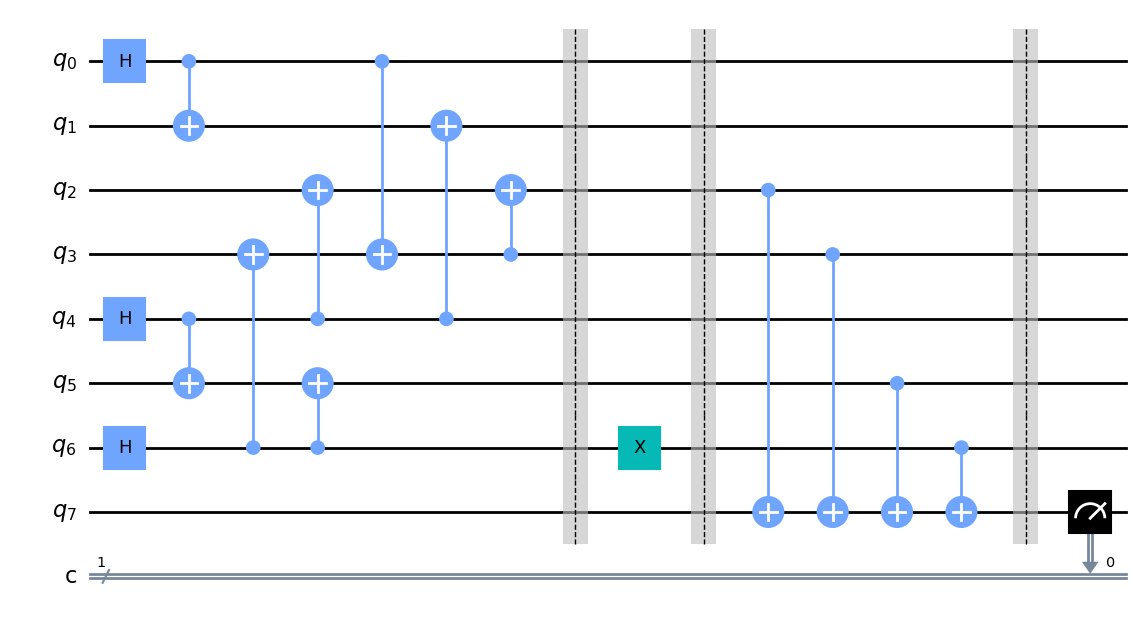

In [51]:
qreg = QuantumRegister(8, "q")
creg = ClassicalRegister(1, "c")

flag_syndrome_x_circuit = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
flag_syndrome_x_circuit.h(qreg[0])
flag_syndrome_x_circuit.h(qreg[4])
flag_syndrome_x_circuit.h(qreg[6])
flag_syndrome_x_circuit.cx(qreg[0], qreg[1])
flag_syndrome_x_circuit.cx(qreg[4], qreg[5])
flag_syndrome_x_circuit.cx(qreg[6], qreg[3])
flag_syndrome_x_circuit.cx(qreg[4], qreg[2])
flag_syndrome_x_circuit.cx(qreg[6], qreg[5])
flag_syndrome_x_circuit.cx(qreg[0], qreg[3])
flag_syndrome_x_circuit.cx(qreg[4], qreg[1])
flag_syndrome_x_circuit.cx(qreg[3], qreg[2])

flag_syndrome_x_circuit.barrier()

# Add single qubit bit-flip error
flag_syndrome_x_circuit.x(qreg[6])

flag_syndrome_x_circuit.barrier()

# Stablizer measuremnt S6=Z3Z4Z6Z7
flag_syndrome_x_circuit.cx(qreg[2],qreg[7])
flag_syndrome_x_circuit.cx(qreg[3],qreg[7])
flag_syndrome_x_circuit.cx(qreg[5],qreg[7])
flag_syndrome_x_circuit.cx(qreg[6],qreg[7])

flag_syndrome_x_circuit.barrier()

flag_syndrome_x_circuit.measure(qreg[7], creg[0])
flag_syndrome_x_circuit.draw('mpl')

In [52]:
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
flag_syndrome_x_circuit= transpile(flag_syndrome_x_circuit, simulator)

# Run and get counts
result = simulator.run(flag_syndrome_x_circuit, shots=100000).result()
counts = result.get_counts(flag_syndrome_x_circuit)
print(counts)

{'1': 100000}


By using one extra flag qubit, the stabilizer measurement $S^f_6 = Z_3Z_4Z_6Z_7$ returns a result of $1$ which tells us that one of $\{q_2, q_3, q_5, q_6\}$ could go wrong. But which one? We can actually tell this using three flag qubits and parallel stabilizer measurement!

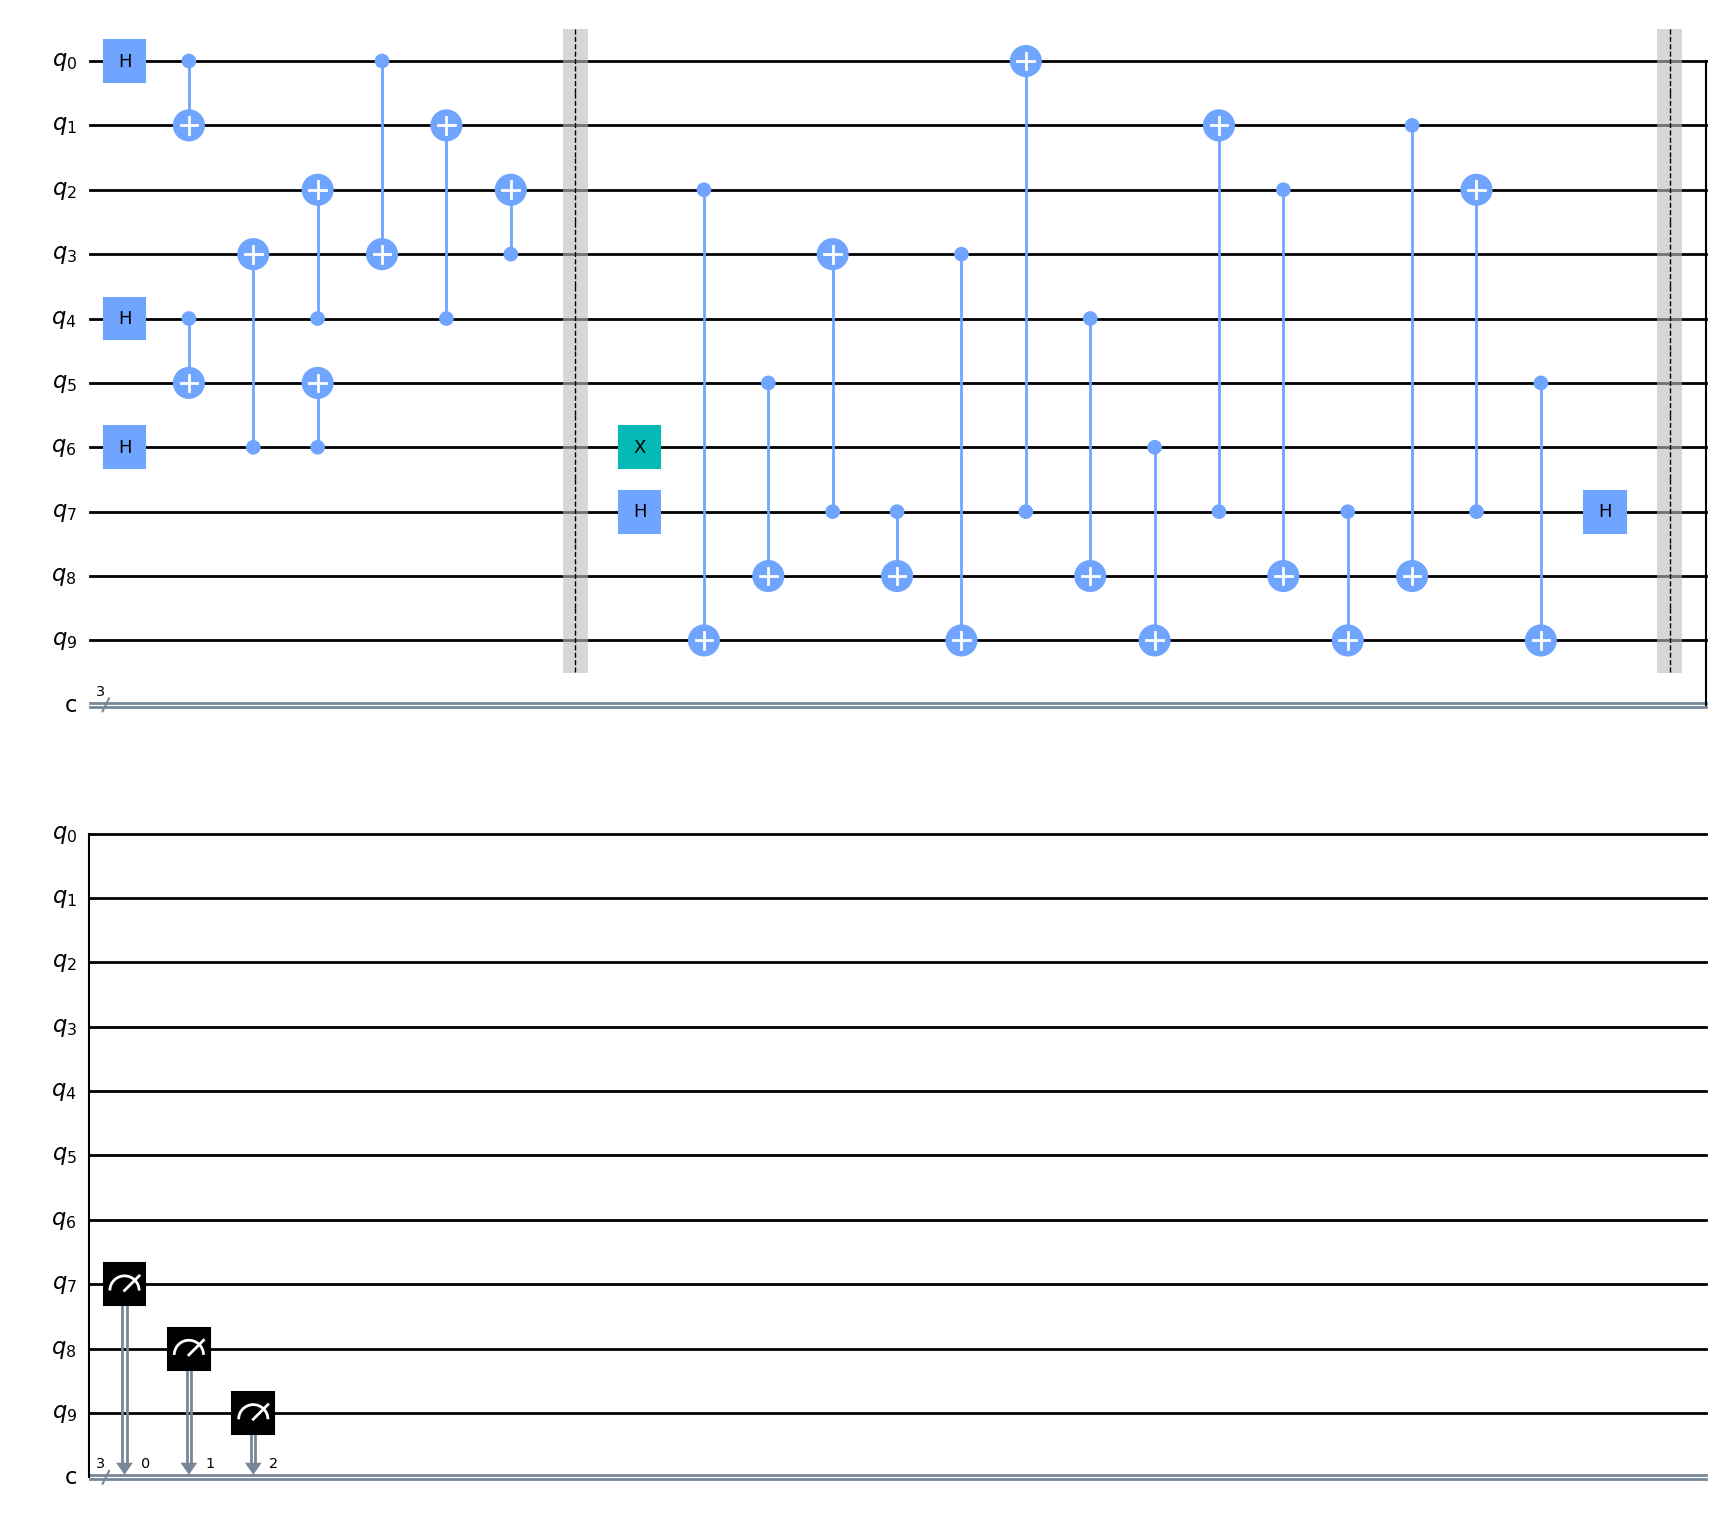

In [53]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flag_syndrome_xzz_circuit = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
flag_syndrome_xzz_circuit.h(qreg[0])
flag_syndrome_xzz_circuit.h(qreg[4])
flag_syndrome_xzz_circuit.h(qreg[6])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[3], qreg[2])

flag_syndrome_xzz_circuit.barrier()

# Add single qubit bit-flip error
flag_syndrome_xzz_circuit.x(qreg[6])

# Stablizer measuremnt S1, S5, S6
flag_syndrome_xzz_circuit.h(qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[0])
flag_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[4],qreg[8])

flag_syndrome_xzz_circuit.cx(qreg[7],qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
flag_syndrome_xzz_circuit.h(qreg[7])

flag_syndrome_xzz_circuit.barrier()

flag_syndrome_xzz_circuit.measure(qreg[7], creg[0])
flag_syndrome_xzz_circuit.measure(qreg[8], creg[1])
flag_syndrome_xzz_circuit.measure(qreg[9], creg[2])
flag_syndrome_xzz_circuit.draw('mpl')

In [54]:
# Run and get counts
result = simulator.run(flag_syndrome_xzz_circuit.reverse_bits(), shots=100000).result()
counts = result.get_counts(flag_syndrome_xzz_circuit)
# plot_histogram(counts, title='')
print(counts)

{'001': 100000}


Now, let's interpret the results. We get a measurement result of $001$. 

- The first flag ancilla qubit checks $S^f_1 = X_1X_2X_3X_4$. $0$ tells us there is no $Z$ error happening on those qubit. 

- The second flag ancilla qubit checks $S^f_5 = Z_2Z_3Z_5Z_6$. $0$ tells us there is no $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S^f_6 = Z_3Z_4Z_6Z_7$. $1$ tells us there is one $X$ error happening on those qubit.

![](./pic/SingleError_Quantinuum.png)


By comparing $S^f_5$ and $S^f_6$ syndromes, we can claim that either $q_3$ or $q_6$ experience a bit-flip $X$ error. Even if we narrow down to 2 candidates, we still don't know which one goes wrong exactly. According to the workflow, we will proceed to check unflagged circuits.

<img src="./pic/QEC-workflow.png" width="500"/>

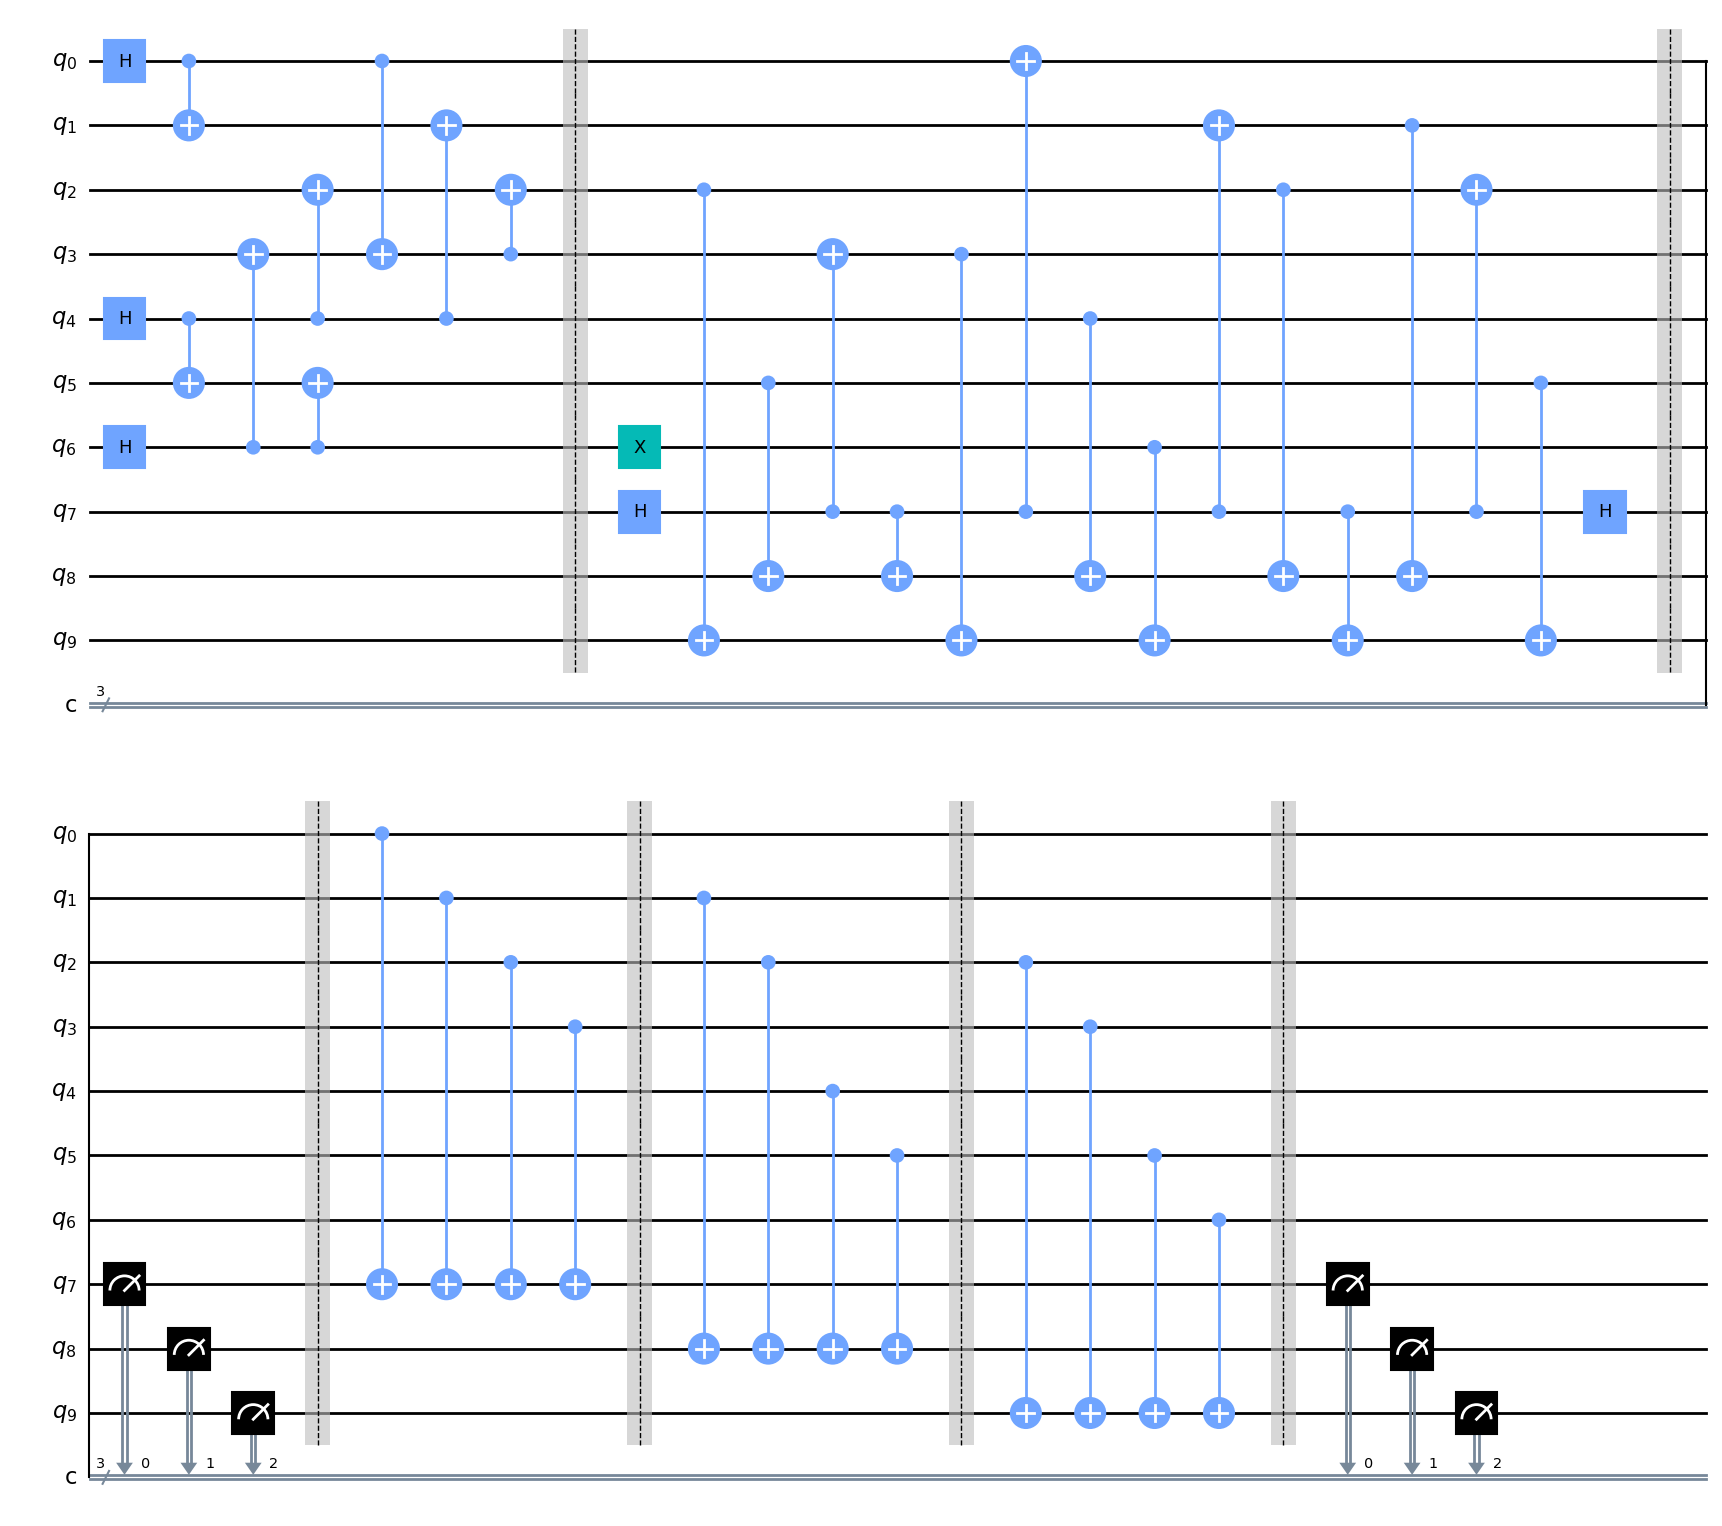

In [55]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flag_syndrome_xzz_circuit = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
flag_syndrome_xzz_circuit.h(qreg[0])
flag_syndrome_xzz_circuit.h(qreg[4])
flag_syndrome_xzz_circuit.h(qreg[6])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[3], qreg[2])

flag_syndrome_xzz_circuit.barrier()

# Add single qubit bit-flip error
flag_syndrome_xzz_circuit.x(qreg[6])

# Stablizer measuremnt S1+S5+S6
flag_syndrome_xzz_circuit.h(qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[0])
flag_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[4],qreg[8])

flag_syndrome_xzz_circuit.cx(qreg[7],qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
flag_syndrome_xzz_circuit.h(qreg[7])

flag_syndrome_xzz_circuit.barrier()
flag_syndrome_xzz_circuit.measure(qreg[7], creg[0])
flag_syndrome_xzz_circuit.measure(qreg[8], creg[1])
flag_syndrome_xzz_circuit.measure(qreg[9], creg[2])

flag_syndrome_xzz_circuit.barrier()

# S4 = Z1Z2Z3Z4
flag_syndrome_xzz_circuit.cx(qreg[0],qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[1],qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[3],qreg[7])
flag_syndrome_xzz_circuit.barrier()

# S5 = Z2Z3Z5Z6
flag_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[4],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
flag_syndrome_xzz_circuit.barrier()

# S6 = Z3Z4Z6Z7
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
flag_syndrome_xzz_circuit.barrier()

flag_syndrome_xzz_circuit.measure(qreg[7], creg[0])
flag_syndrome_xzz_circuit.measure(qreg[8], creg[1])
flag_syndrome_xzz_circuit.measure(qreg[9], creg[2])
flag_syndrome_xzz_circuit.draw('mpl')

In [56]:
# Run and get counts
result = simulator.run(flag_syndrome_xzz_circuit.reverse_bits(), shots=100000).result()
counts = result.get_counts(flag_syndrome_xzz_circuit)
# plot_histogram(counts, title='')
print(counts)

{'000': 100000}


### Hook qubit error

The following is an example of single qubit bit-flip $X$ error happening on the 8-th falg qubit. This hook error can not be detected with stabilizer $X_2X_3X_5X_6$!

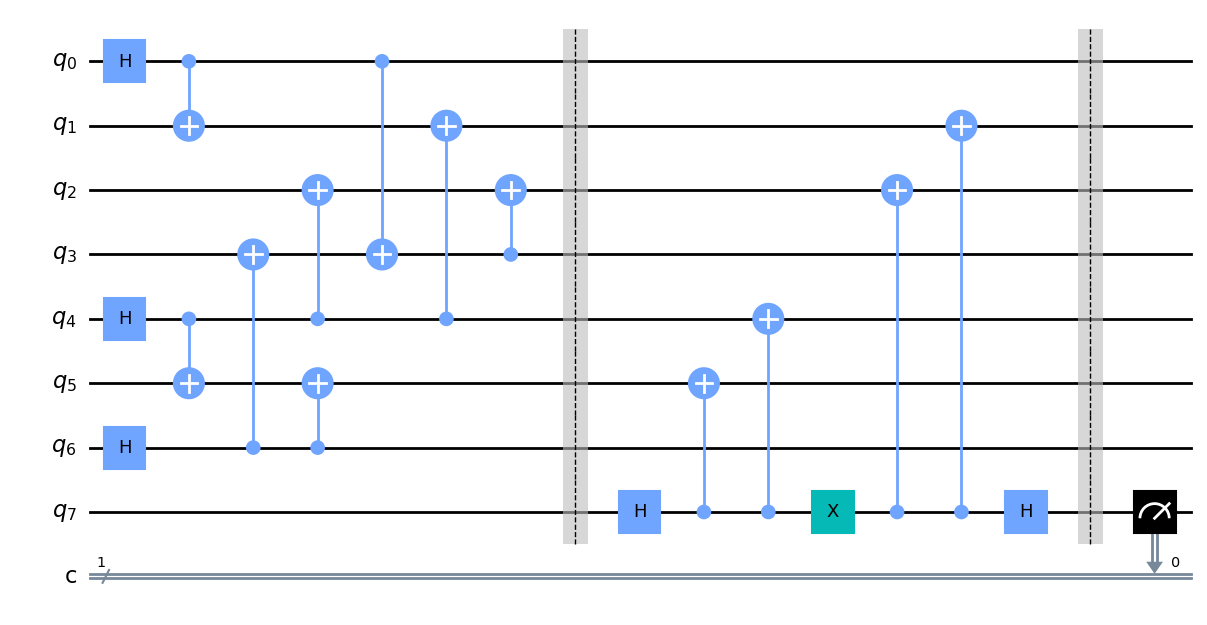

In [57]:
qreg = QuantumRegister(8, "q")
creg = ClassicalRegister(1, "c")

flag_syndrome_x_circuit = QuantumCircuit(qreg, creg)

flag_syndrome_x_circuit.h(qreg[0])
flag_syndrome_x_circuit.h(qreg[4])
flag_syndrome_x_circuit.h(qreg[6])
flag_syndrome_x_circuit.cx(qreg[0], qreg[1])
flag_syndrome_x_circuit.cx(qreg[4], qreg[5])
flag_syndrome_x_circuit.cx(qreg[6], qreg[3])
flag_syndrome_x_circuit.cx(qreg[4], qreg[2])
flag_syndrome_x_circuit.cx(qreg[6], qreg[5])
flag_syndrome_x_circuit.cx(qreg[0], qreg[3])
flag_syndrome_x_circuit.cx(qreg[4], qreg[1])
flag_syndrome_x_circuit.cx(qreg[3], qreg[2])

flag_syndrome_x_circuit.barrier()

flag_syndrome_x_circuit.h(qreg[7])
flag_syndrome_x_circuit.cx(qreg[7],qreg[5])
flag_syndrome_x_circuit.cx(qreg[7],qreg[4])
flag_syndrome_x_circuit.x(qreg[7])
flag_syndrome_x_circuit.cx(qreg[7],qreg[2])
flag_syndrome_x_circuit.cx(qreg[7],qreg[1])
flag_syndrome_x_circuit.h(qreg[7])

flag_syndrome_x_circuit.barrier()

flag_syndrome_x_circuit.measure(qreg[7], creg[0])
flag_syndrome_x_circuit.draw('mpl')

In [58]:
# Run and get counts
result = simulator.run(flag_syndrome_x_circuit, shots=100000).result()
counts = result.get_counts(flag_syndrome_x_circuit)
# plot_histogram(counts, title='')
print(counts)

{'0': 100000}


Again, we need three ancilla qubits to generate the flagged syndrome measurement.

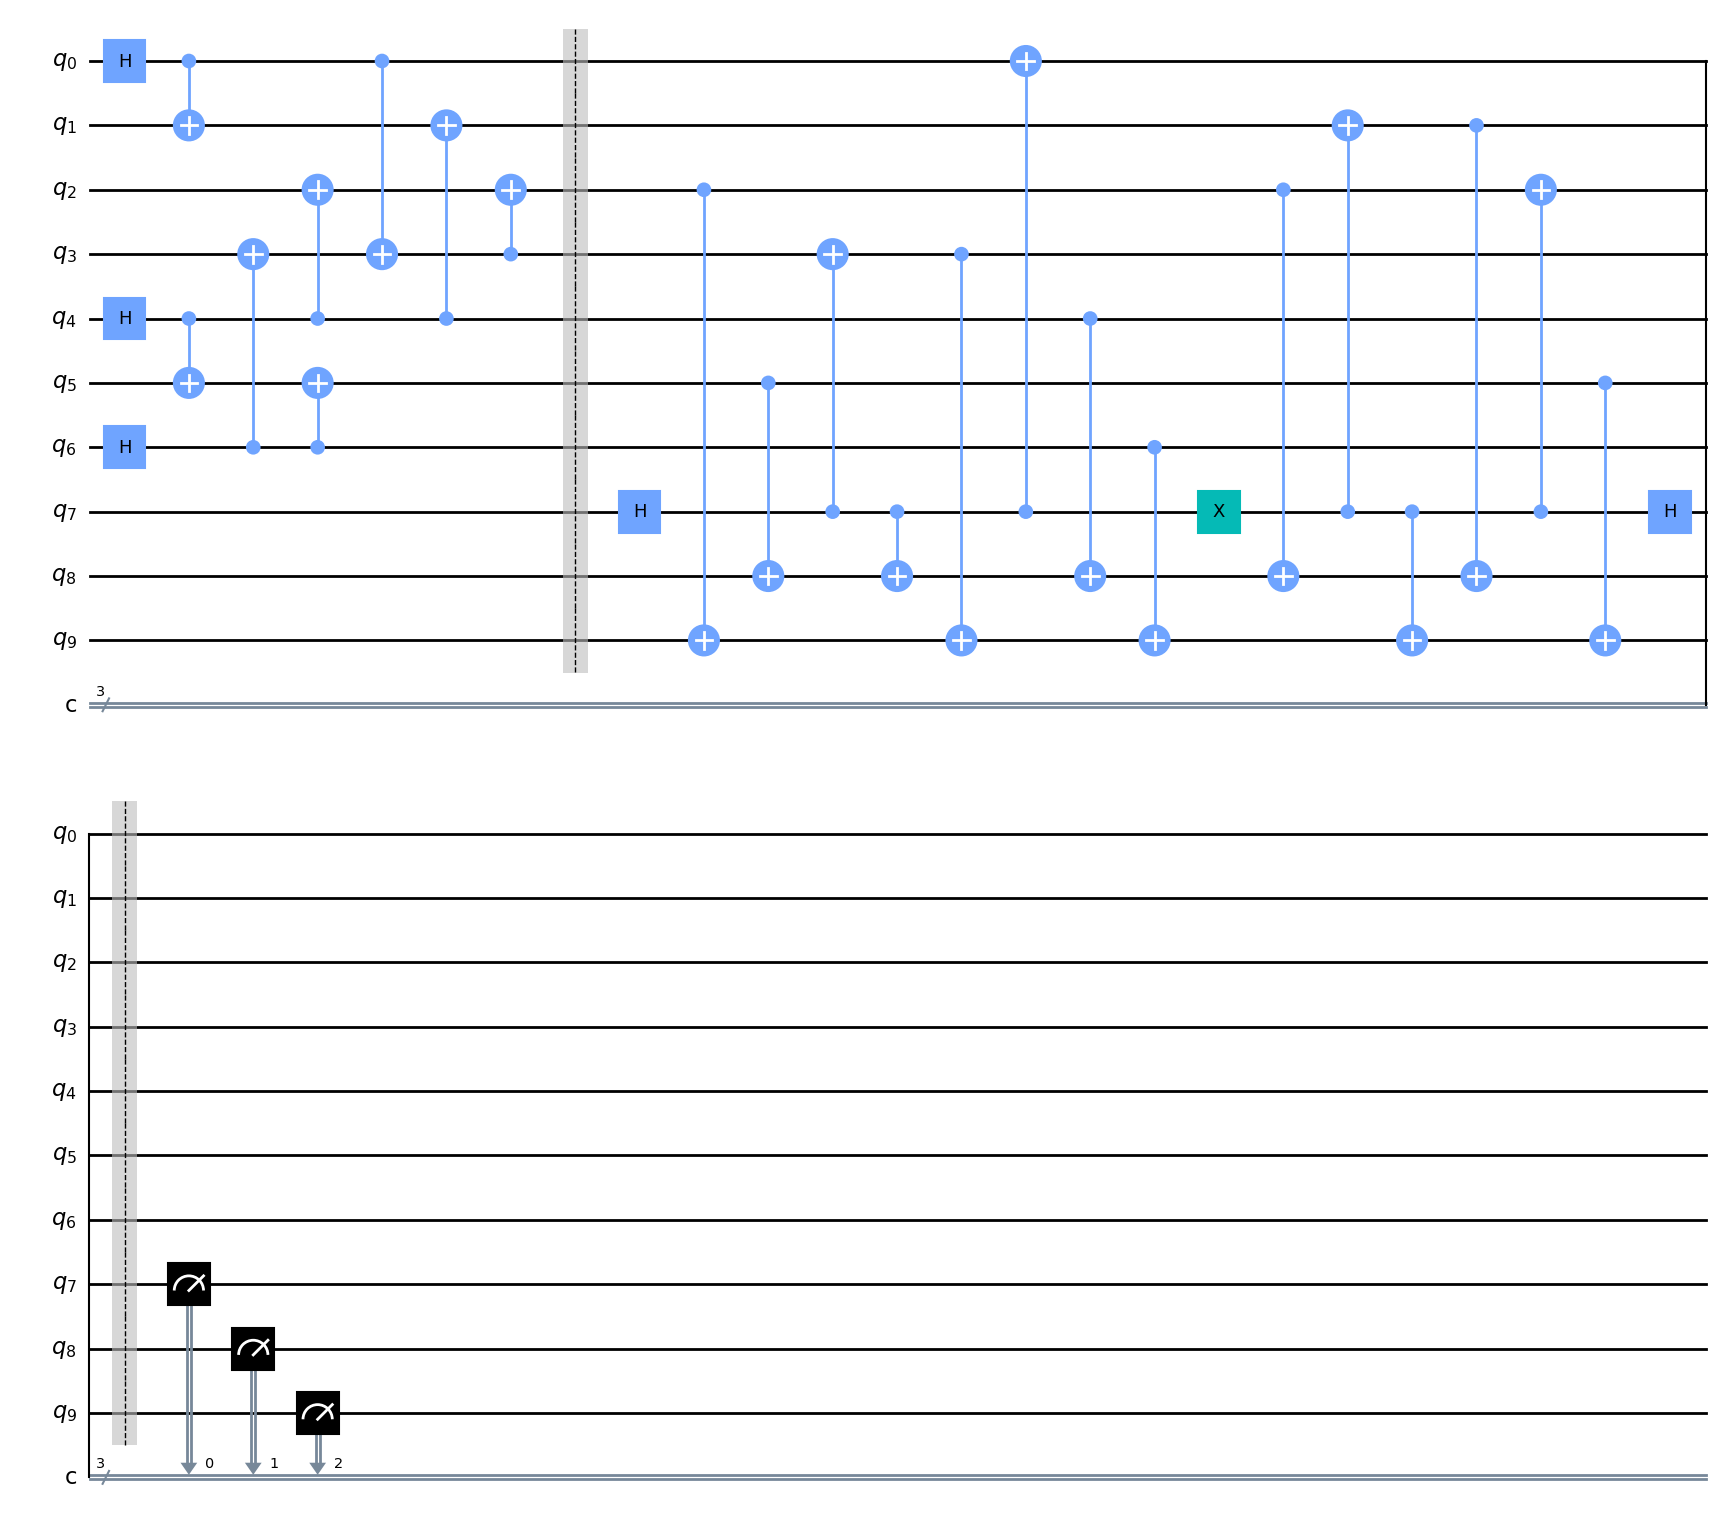

In [59]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flag_syndrome_xzz_circuit = QuantumCircuit(qreg, creg)

flag_syndrome_xzz_circuit.h(qreg[0])
flag_syndrome_xzz_circuit.h(qreg[4])
flag_syndrome_xzz_circuit.h(qreg[6])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[6], qreg[5])
flag_syndrome_xzz_circuit.cx(qreg[0], qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[4], qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[3], qreg[2])

flag_syndrome_xzz_circuit.barrier()

# Adding single qubit error on 7-th data qubit
# flag_syndrome_xzz_circuit.x(qreg[6])

flag_syndrome_xzz_circuit.h(qreg[7])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[3])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[0])
flag_syndrome_xzz_circuit.cx(qreg[3],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[4],qreg[8])

# Adding hook qubit error on ancilla qubit
flag_syndrome_xzz_circuit.x(qreg[7])

flag_syndrome_xzz_circuit.cx(qreg[7],qreg[1])
flag_syndrome_xzz_circuit.cx(qreg[6],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[2],qreg[8])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[7],qreg[2])
flag_syndrome_xzz_circuit.cx(qreg[5],qreg[9])
flag_syndrome_xzz_circuit.cx(qreg[1],qreg[8])
flag_syndrome_xzz_circuit.h(qreg[7])

flag_syndrome_xzz_circuit.barrier()

flag_syndrome_xzz_circuit.measure(qreg[7], creg[0])
flag_syndrome_xzz_circuit.measure(qreg[8], creg[1])
flag_syndrome_xzz_circuit.measure(qreg[9], creg[2])
flag_syndrome_xzz_circuit.draw('mpl')

In [60]:
# Run and get counts
result = simulator.run(flag_syndrome_xzz_circuit.reverse_bits(), shots=100000).result()
counts = result.get_counts(flag_syndrome_xzz_circuit)
# plot_histogram(counts, title='')
print(counts)

{'011': 100000}


Now, let's interpret the results. We get a measurement result of $011$. **Notice this is a weight-2 error!**

- The first flag ancilla qubit checks $S^f_1 = X_1X_2X_3X_4$. $0$ tells us there is no $Z$ error happening on those qubit. 

- The second flag ancilla qubit checks $S^f_5 = Z_2Z_3Z_5Z_6$. $1$ tells us there is one $X$ error happening on those qubit.

- The third flag ancilla qubit checks $S^f_6 = Z_3Z_4Z_6Z_7$. $1$ tells us there is one $X$ error happening on those qubit.


![](./pic/HookError_Quantinuum.png)

## Second flagged parallel circuit $\{S^f_2, S^f_3, S^f_4\}$

<img src="./pic/second-flag.png" width="500"/>

### Single qubit error

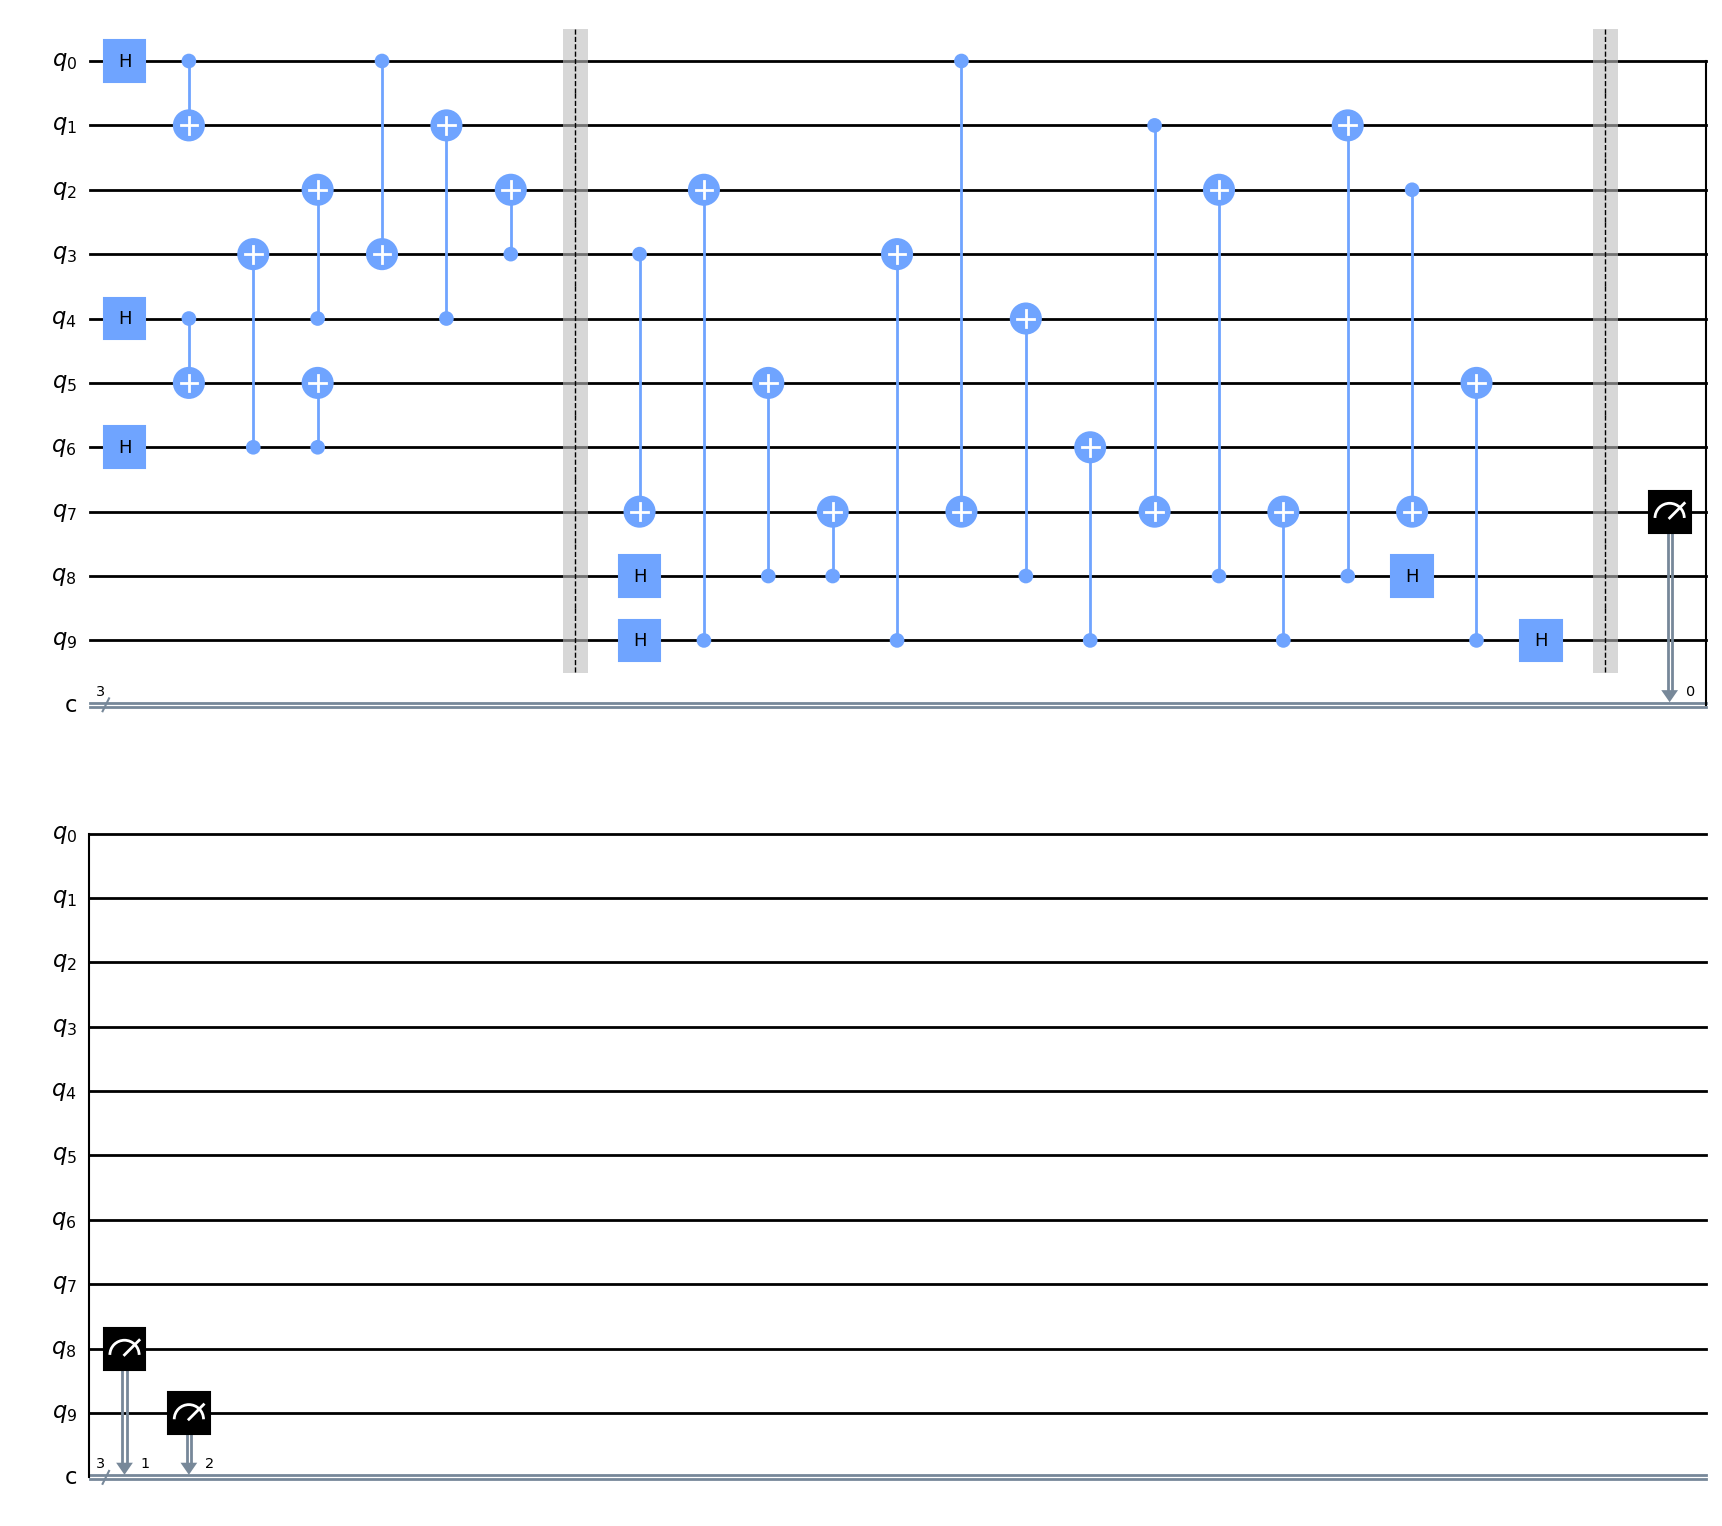

In [61]:
qreg = QuantumRegister(10, "q")
creg = ClassicalRegister(3, "c")

flagged_parallel_circuit_2 = QuantumCircuit(qreg, creg)

# Encoding circuit to create the logical basis states
flagged_parallel_circuit_2.h(qreg[0])
flagged_parallel_circuit_2.h(qreg[4])
flagged_parallel_circuit_2.h(qreg[6])
flagged_parallel_circuit_2.cx(qreg[0], qreg[1])
flagged_parallel_circuit_2.cx(qreg[4], qreg[5])
flagged_parallel_circuit_2.cx(qreg[6], qreg[3])
flagged_parallel_circuit_2.cx(qreg[4], qreg[2])
flagged_parallel_circuit_2.cx(qreg[6], qreg[5])
flagged_parallel_circuit_2.cx(qreg[0], qreg[3])
flagged_parallel_circuit_2.cx(qreg[4], qreg[1])
flagged_parallel_circuit_2.cx(qreg[3], qreg[2])

flagged_parallel_circuit_2.barrier()

flagged_parallel_circuit_2.h(qreg[8])
flagged_parallel_circuit_2.h(qreg[9])

flagged_parallel_circuit_2.cx(qreg[3], qreg[7])
flagged_parallel_circuit_2.cx(qreg[9], qreg[2])
flagged_parallel_circuit_2.cx(qreg[8], qreg[5])
flagged_parallel_circuit_2.cx(qreg[8], qreg[7])
flagged_parallel_circuit_2.cx(qreg[0], qreg[7])
flagged_parallel_circuit_2.cx(qreg[9], qreg[3])
flagged_parallel_circuit_2.cx(qreg[8], qreg[4])
flagged_parallel_circuit_2.cx(qreg[1], qreg[7])
flagged_parallel_circuit_2.cx(qreg[9], qreg[6])
flagged_parallel_circuit_2.cx(qreg[8], qreg[2])
flagged_parallel_circuit_2.cx(qreg[9], qreg[7])
flagged_parallel_circuit_2.cx(qreg[2], qreg[7])
flagged_parallel_circuit_2.cx(qreg[8], qreg[1])
flagged_parallel_circuit_2.cx(qreg[9], qreg[5])

flagged_parallel_circuit_2.h(qreg[8])
flagged_parallel_circuit_2.h(qreg[9])

flagged_parallel_circuit_2.barrier()

flagged_parallel_circuit_2.measure(qreg[7:], creg)

flagged_parallel_circuit_2.draw("mpl", cregbundle=True)

### Hook qubit error

---
Here is the code we want to generate from this section.

![](./pic/QEC-pseudo-code.png)

In [62]:
import qiskit.tools.jupyter
%qiskit_version_table